In [56]:
import sys
sys.path.append("../")

In [57]:
from datetime import datetime
from functools import partial
from matplotlib.dates import DateFormatter
from ta import add_all_ta_features
from ta.utils import dropna
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
keras.config.enable_unsafe_deserialization()

from draw_image_utils import draw_prediction

In [58]:
symbol_mapping = {
    "CTG": {
        "dataset_folder": "ctg_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "FPT": {
        "dataset_folder": "fpt_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "TCB": {
        "dataset_folder": "tcb_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "VN30": {
        "dataset_folder": "vn30_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend_1_1_1",
        "freq_of_date": "B"
    },
    # "BTC": {
    #     "dataset_folder": "btc_with_ema_macd_trend",
    #     "model_name": "model_5_biLSTM_ema_macd_trend",
    #     "freq_of_date": "D"
    # },
    "BTC": {
        "dataset_folder": "btc_with_ema_macd_trend",
        "model_name": "model_5_biLSTM_ema_macd_trend_1_1_1_1_1_1",
        "freq_of_date": "D"
    },
    "COCA_COLA": {
        "dataset_folder": "coca_cola_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend_1_1_1",
        "freq_of_date": "D"
    },
    "ETH": {
        "dataset_folder": "eth_with_ema_macd_trend",
        "model_name": "model_5_biLSTM_ema_macd_trend_1_1",
        "freq_of_date": "D"
    },
    "APPLE": {
        "dataset_folder": "apple_with_ema_macd_trend",
        "model_name": "model_5_biLSTM_ema_macd_trend_1_1",
        "freq_of_date": "D"
    },
}

In [59]:
symbol = input("Symbol = ").strip().upper()
dataset_folder_name = symbol_mapping[symbol]["dataset_folder"]
model_name = symbol_mapping[symbol]["model_name"]
dataset_folder = f"../dataset/{dataset_folder_name}"
index_of_image_input = 3
batch_size = 100
freq_of_date = symbol_mapping[symbol]["freq_of_date"] # B or D

config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [60]:
function_transform_origin = get_origin_transform_function(
    os.path.join(
        os.path.abspath(f"{dataset_folder}/model_save/{model_name}"),
        "config_and_loss.json"
    )
)
path_of_model = f"{dataset_folder}/model_save/{model_name}/{model_name}.keras"
model = keras.models.load_model(os.path.abspath(path_of_model))


In [61]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)


In [62]:
image_shape = get_image_shape(dataset_test, index_of_image_input)

In [63]:
config_of_continue_learning_folder = read_config(dataset_folder)
file_csv_path = config_of_continue_learning_folder["file_csv"]
df_get_from_api = pd.read_csv(file_csv_path)
df_get_from_api["Date"] = pd.to_datetime(df_get_from_api["Date"])

In [64]:
def date_generator(date_i):
    index_of_date = get_date_index(df_get_from_api, date_i)
    total_days = previous_days + 1 + next_days + days_result
    all_dates = df_get_from_api[index_of_date:index_of_date + total_days]["Date"].dt.date
    total_date_reals = len(all_dates)
    dates_real = all_dates
    if len(all_dates) < total_days:
        all_dates = pd.date_range(start=str(date_i), periods=total_days, freq=freq_of_date)
    return list(all_dates), total_date_reals

In [65]:
dataset_test_1 = dataset_test
dataset_test_2 = dataset_test_1.batch(batch_size)
transform_function = partial(function_transform_origin, days_result)
dataset_test_3 = dataset_test_2.map(transform_function)

In [66]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 287, 287,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 286, 286,  │        104 │ image_input[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 143, 143,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 163592)    │          0 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ema_9_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macd_history_input  │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trend_type_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │ 10,469,952 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 8)         │         24 │ ema_9_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 8)         │         24 │ macd_history_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 8)         │         16 │ trend_type_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 88)        │          0 │ dense_44[0][0],   │
│ (Concatenate)       │                   │            │ dense_45[0][0],   │
│                     │                   │            │ dense_42[0][0],   │
│                     │                   │            │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 64)        │      5,696 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64)        │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 64)        │      4,160 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 3, 64)     │          0 │ dense_47[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 3, 256)    │    197,632 │ repeat_vector_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 33,217,087 (126.71 MB)

 Trainable params: 11,072,362 (42.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,144,725 (84.48 MB)

In [67]:
loss = model.evaluate(dataset_test_3)

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4047 - mae: 0.8703 - mse: 1.4047 


In [68]:
loss

[1.3958797454833984, 0.8672536015510559, 1.3958799839019775]

In [69]:
prediction_for_test = model.predict(dataset_test_3)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/stepWARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000244C9EC9790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


In [70]:
print(prediction_for_test)

[[[0.09552204 0.11516834]
  [0.09510253 0.11535636]
  [0.09504056 0.11531444]]

 [[0.09552196 0.11516839]
  [0.0951025  0.11535639]
  [0.09504053 0.11531448]]

 [[0.09552204 0.11516834]
  [0.09510253 0.11535636]
  [0.09504056 0.11531444]]

 [[0.09552202 0.11516835]
  [0.09510253 0.11535637]
  [0.09504056 0.11531445]]

 [[0.09552203 0.11516834]
  [0.09510253 0.11535636]
  [0.09504056 0.11531444]]

 [[0.09552203 0.11516835]
  [0.09510253 0.11535636]
  [0.09504056 0.11531445]]

 [[0.09552205 0.11516834]
  [0.09510253 0.11535636]
  [0.09504056 0.11531444]]

 [[0.09552203 0.11516834]
  [0.09510253 0.11535636]
  [0.09504056 0.11531444]]

 [[0.09552202 0.11516835]
  [0.09510253 0.11535637]
  [0.09504055 0.11531445]]

 [[0.09552201 0.11516836]
  [0.09510252 0.11535638]
  [0.09504055 0.11531445]]

 [[0.09552184 0.11516847]
  [0.09510243 0.11535645]
  [0.09504048 0.11531456]]

 [[0.09552198 0.11516838]
  [0.0951025  0.11535639]
  [0.09504054 0.11531448]]

 [[0.09552184 0.11516847]
  [0.09510243 

In [71]:
len(prediction_for_test)

103

In [72]:
all_dates = unwrap_dataset_at_index(dataset_test, 5, to_numpy=True, map_function=lambda date: str(datetime.fromisoformat(date.decode("utf-8")).date()))
trend_dataset_test_2 = unwrap_dataset_at_index(unwrap_dataset_at_index(dataset_test_2, 2, batch=True, to_numpy=True), 0)
_4_prices_of_all_days_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 4, batch=True, to_numpy=True)
image_input_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 3, batch=True, to_numpy=True)
real_percent_last_days_result_dataset_test_3 = unwrap_dataset_at_index(dataset_test_3, 1, batch=True, to_numpy=True) 

In [73]:
mapping_trend_type = {
    1: "GROUP_BULL",
    -1: "GROUP_BEAR",
    0: "GROUP_SIZEWAY",
}

real: [[ 4.94024201e-02  4.69607187e-01]
 [ 3.63606424e-01  3.79626486e-06]
 [-3.14876554e+00 -2.77752547e+00]]
prediction: [[0.09552204 0.11516834]
 [0.09510253 0.11535636]
 [0.09504056 0.11531444]]


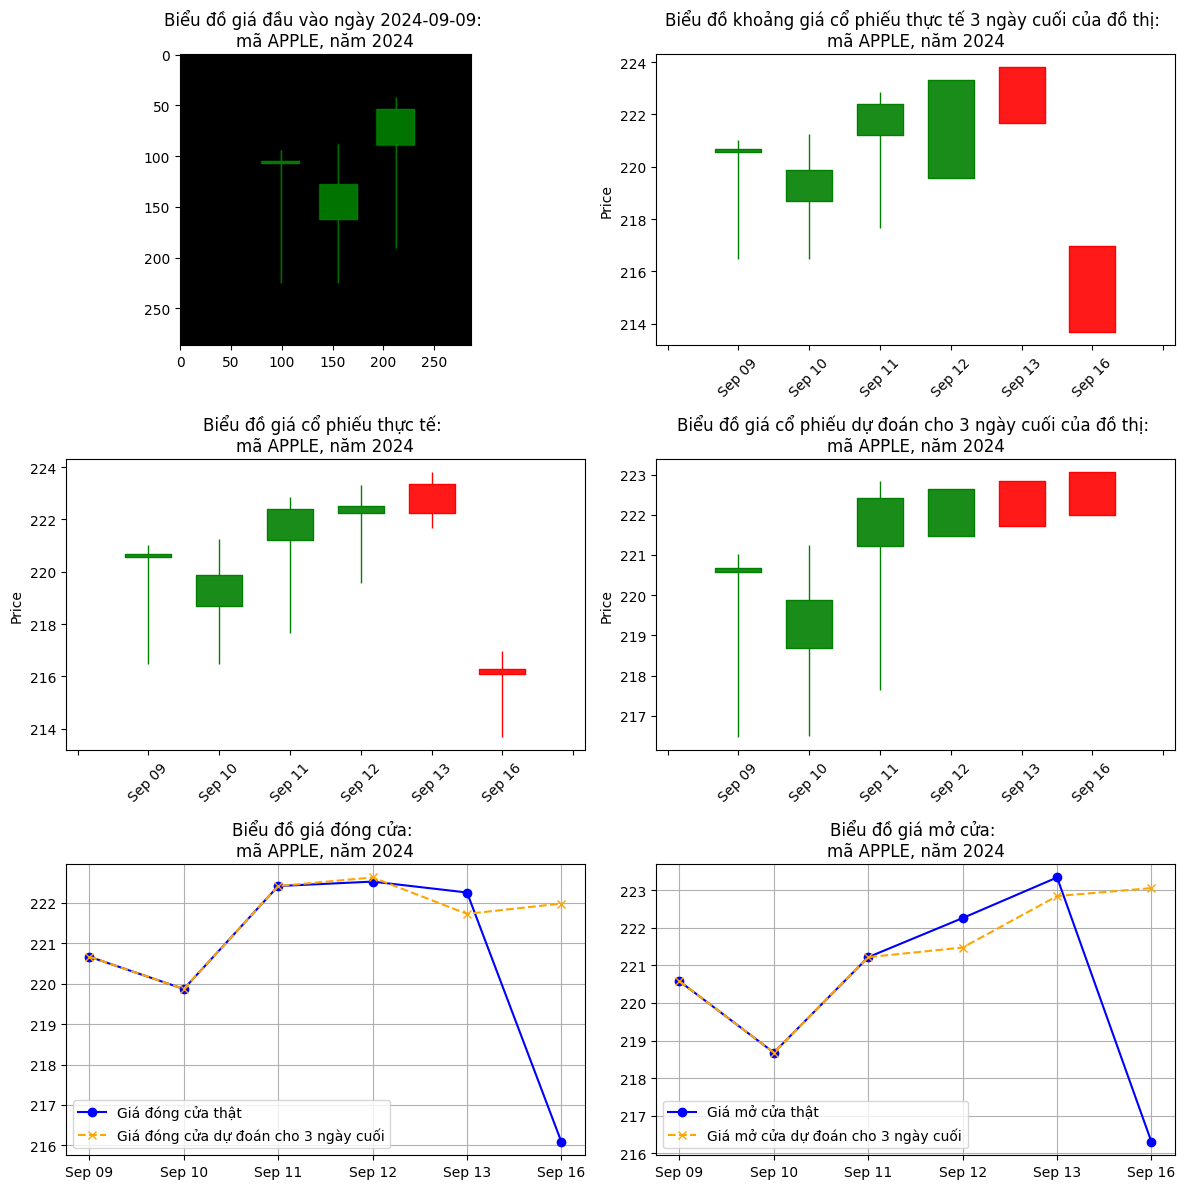

In [74]:
index = 2
print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
print(f"prediction: {prediction_for_test[index]}")
type_of_output = "open_and_close"
draw_prediction(
    image_input_dataset_test_2[index], 
    _4_prices_of_all_days_dataset_test_2[index], 
    all_dates[index],
    prediction_for_test[index], 
    show_x_orginal_candle=True,
    show_prediction_candle=True, 
    show_original_candle=True,
    show_close_compare=True,
    show_open_compare=True,
    type_of_output=type_of_output,
    draw_beside=True,
    print_image=True,
    extend_real=True,
    date_generator=date_generator,
    symbol=symbol)

In [79]:
# index = 0
is_print_all = input("Print all? (y/n): ").lower()[0] == "y"
type_of_output = "open_and_close"
if is_print_all:
    group = input("Group to print? (bull/bear/sizeway/all) ").strip().lower()
    is_extend_real = input("Extend real? (y/n): ").strip().lower()[0] == "y"
    if "bull" in group:
        group = "GROUP_BULL"
    elif "bear" in group:
        group = "GROUP_BEAR"
    elif "sizeway" in group:
        group = "GROUP_SIZEWAY"
    elif len(group) == 0 or "all" in group:
        group = None
        
    folder_name = f"{model_name}"
    if group is not None:
        folder_name += f"/{group}"
    
    if is_extend_real:
        folder_name = f"extend_real_{folder_name}"
    folder_save_image_predict = f"{dataset_folder}/output_prediction_image/{folder_name}"
    
    os.makedirs(folder_save_image_predict, exist_ok=False)
    
    date_printed = set()
    for index in range(len(_4_prices_of_all_days_dataset_test_2)):
        if index % 10 == 0:
            print(f"---------------- Save: {index}/{len(_4_prices_of_all_days_dataset_test_2)} images")
        print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
        print(f"prediction: {prediction_for_test[index]}")
        date = all_dates[index]
        if date in date_printed:
            continue
        else:
            date_printed.add(date)
        
        trend_type = mapping_trend_type[trend_dataset_test_2[index]]
        
        if group is not None:
            if trend_type != group:
                continue
        
        draw_prediction(
            image_input_dataset_test_2[index], 
            _4_prices_of_all_days_dataset_test_2[index], 
            date,
            prediction_for_test[index], 
            show_x_orginal_candle=True,
            show_prediction_candle=True, 
            show_original_candle=True,
            show_close_compare=True,
            show_open_compare=True,
            type_of_output=type_of_output,
            draw_beside=True,
            save_image=f"{folder_save_image_predict}/{date}_{trend_type}_predict.png",
            print_image=False,
            extend_real=is_extend_real,
            date_generator=date_generator,
            symbol=symbol)

---------------- Save: 0/103 images
real: [[ 0.14988706  0.48745824]
 [ 0.3741501  -0.33515891]
 [-0.04823899  0.21681714]]
prediction: [[0.09552204 0.11516834]
 [0.09510253 0.11535636]
 [0.09504056 0.11531444]]
real: [[ 0.56065421 -0.82596746]
 [-0.41705369  0.50327142]
 [ 0.14988706  0.48745824]]
prediction: [[0.09552196 0.11516839]
 [0.0951025  0.11535639]
 [0.09504053 0.11531448]]
real: [[ 4.94024201e-02  4.69607187e-01]
 [ 3.63606424e-01  3.79626486e-06]
 [-3.14876554e+00 -2.77752547e+00]]
prediction: [[0.09552204 0.11516834]
 [0.09510253 0.11535636]
 [0.09504056 0.11531444]]
real: [[-0.51733902 -0.48856884]
 [ 3.25705985  2.65900405]
 [ 1.55330253  1.74109705]]
prediction: [[0.09552202 0.11516835]
 [0.09510253 0.11535637]
 [0.09504056 0.11531445]]
real: [[ 1.29443896  2.21892833]
 [ 0.16767913  0.23153974]
 [-0.26553075 -1.16660506]]
prediction: [[0.09552203 0.11516834]
 [0.09510253 0.11535636]
 [0.09504056 0.11531444]]
real: [[1.70896236 1.48974799]
 [0.29048464 0.35689869]
 [1.

In [80]:
folder_save_image_predict

'../dataset/apple_with_ema_macd_trend/output_prediction_image/extend_real_model_5_biLSTM_ema_macd_trend_1_1/GROUP_SIZEWAY'